# Classifying simulated events using a Convolutional Neural Network

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score)
from helper_functions import normalize_image_data, plot_history, plot_roc_auc
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Load images and labels.
DATA_PATH = "../data/"

images = np.load(DATA_PATH+"images_training.npy")
labels = np.load(DATA_PATH+"labels_training.npy")

# Split the training indices into training and validation. 
# Validate with 25% of the data (default). Can be adjusted.
x_idx = np.arange(images.shape[0])
train_idx, val_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.25)

## Reshaping data for CNNs
The convolutional layers we'll be using expect the inputs to have 4 dimensions:\
(samples, M, N, channels).\
M and N are the image dimensions, 16x16, but while RGB images have 3 channels, ours currently has 0, but should have 1.\
We solve this by just adding an empty axis.

In [3]:
images = images.reshape(images.shape[0], 16, 16, 1)
print(images.shape)

(9000, 16, 16, 1)


# Model
Now, you can build your own network from scratch, and that's a useful exercise. We're going to skip that
here, and use one of the popular, exisiting frameworks that are widely used in current research.
The most used base frameworks are [TensorFlow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), and [Keras](https://keras.io/). Keras is a high-level API that abstracts a large amount of the process of building,
training, and testing a model. You will need either TensorFlow or PyTorch, and the Keras API will automatically
detect which base framework you have.

## Build and compile

In [4]:
# Instantiate the Sequential model, and add layers to it.
model = Sequential()

# The model we build here is the one that has currently performed best when classifying the detector images.
model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape= (16,16,1)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [5]:
# Once the model is built, we need to compile it. This is where we specify the loss function,
# optimizer, and any metrics we need, even custom ones.

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
dense (Dense)                (None, 6, 6, 128)         8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

## Training
This is the point where we normalize our data, just as we pass it to the training function of the model.
The training run will display the progress as it goes through each batch.
$$ \text{num_batches} = \frac{\text{num_samples}}{\text{batch_size}}$$

In [6]:
# Set parameters for the training.
batch_size = 32
epochs = 20

In [7]:
# Setting validation data requires a tuple (val_input, val_targets). You can also just pass the
# entire training set without splitting, and specify validation_split instead of validation_data.
# The the model handles the splitting.

val_data = (normalize_image_data(images[val_idx]), labels[val_idx])
history = model.fit(
    x=normalize_image_data(images[train_idx]),
    y=labels[train_idx],
    validation_data=val_data,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
211/211 [==============================] - 2s 9ms/step - loss: 0.5372 - accuracy: 0.7154 - val_loss: 0.4495 - val_accuracy: 0.7733
Epoch 2/20
211/211 [==============================] - 2s 9ms/step - loss: 0.4396 - accuracy: 0.7950 - val_loss: 0.4209 - val_accuracy: 0.8298
Epoch 3/20
211/211 [==============================] - 2s 9ms/step - loss: 0.3770 - accuracy: 0.8382 - val_loss: 0.3673 - val_accuracy: 0.8471
Epoch 4/20
211/211 [==============================] - 2s 8ms/step - loss: 0.3506 - accuracy: 0.8604 - val_loss: 0.4040 - val_accuracy: 0.8191
Epoch 5/20
211/211 [==============================] - 2s 8ms/step - loss: 0.3182 - accuracy: 0.8750 - val_loss: 0.3740 - val_accuracy: 0.8458
Epoch 6/20
211/211 [==============================] - 2s 8ms/step - loss: 0.2972 - accuracy: 0.8844 - val_loss: 0.2688 - val_accuracy: 0.8969
Epoch 7/20
211/211 [==============================] - 2s 9ms/step - loss: 0.2980 - accuracy: 0.8868 - val_loss: 0.3353 - val_accuracy: 0.8613
Epoch 

# Evaluate the model

## Plot history of loss and accuracy

(<Figure size 1008x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdcf70f310>,
       dtype=object))

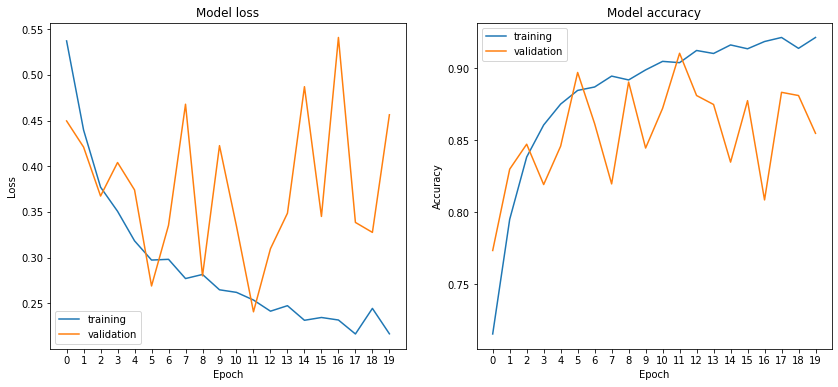

In [8]:
# Use the function we stored in helper_functions.py
plot_history(history)

## Collection of metrics
* Accuracy
* Confusion Matrix
* F1-score
* Matthews Correlation Coefficient
* ROC-Curve and Area Under Curve

Check out the notebook on logistic regression for details around the metrics.

In [9]:
# Predict on the validation set
pred = model.predict([normalize_image_data(images[val_idx])])
# Convert sigmoid values from prediction to integers for the metric functions
result = pred > 0.5

In [10]:
accuracy = accuracy_score(labels[val_idx], result)
confmat = confusion_matrix(labels[val_idx], result)
f1 = f1_score(labels[val_idx], result)
mcc = matthews_corrcoef(labels[val_idx], result)

In [11]:
# Print the metrics in an orderly fashion
print("Confusion matrix:\n", confmat)
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("MCC:", mcc)

Confusion matrix:
 [[1106    0]
 [ 327  817]]
Accuracy: 0.8546666666666667
F1-score: 0.833248342682305
MCC: 0.742424823373654


## ROC-curve and Area Under Curve
### All events

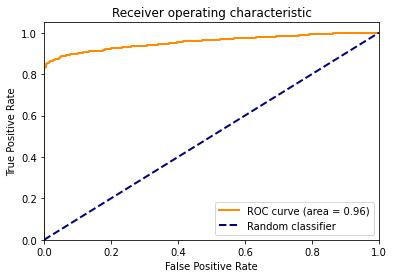

In [14]:
plot_roc_auc(labels[val_idx], pred)